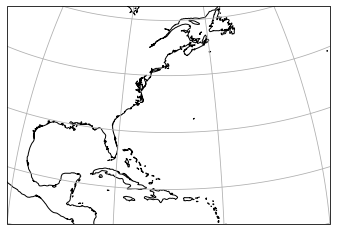

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import csv
from sklearn.preprocessing import StandardScaler

import datetime
import cartopy.crs as ccrs
import cftime

import utils

In [2]:
# Takes in a file of data and searches for row headers (i.e. the rows that correspond to a unique hurricane).
# Returns the data as a dataframe, with the row header ID as the first column.
def clean_file(filename):
    
    f = open(filename, mode='r')
    reader = csv.reader(f)
    header = []
    data = [] # 2d list to hold all the data
    for row in reader:
        if row[0].startswith("AL"): # Header row
            header = row[0]
        else:
            row.insert(0, header)# append ID to row
            data.append(row[:-1]) # don't know why theres an extra empty column
    f.close()
    df = pd.DataFrame(data, columns=['ID','Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude',
                               'Wind speed','Pressure','34NE','34SE','34SW','34NW',
                               '50NE','50SE','50SW','50NW','64NE','64SE','64SW','64NW'])
    df['Date'] = df['Date'].apply(utils.convert_time)
    
    df['Latitude'] = df['Latitude'].apply(utils.convert_coords)
    df['Longitude'] = df['Longitude'].apply(utils.convert_coords)
    return df

In [3]:
'''
Takes in a pandas dataframe of hurricane data and:
(1) Change the record identifier column into 1 if hurricane made Landfall (L), else 0
(2) adjust the date column into 3 separate columns - month, day, year. Drops date column.
(3) Imputes missing values with the mean of the column of the truncated data
(4) Standardize data for columns of continuous variables
'''


def prep_hurricane_data(df):
    
    # change record identifier (1)
    df['Record'] = pd.Series(df['Record'] == ' L', dtype=int)
    #df['Status'] = df['Status'].map({' TD':0,' TS':1,' HU':2,' EX':3,' SD':4,' SS':5,' LO':6,' WV':7,' DB':8})
    df.drop('ID', axis = 1, inplace = True)
    df.drop('Status', axis = 1, inplace = True) # this column doesn't have much useful info for our goals, its just used to categorize hurricane type
    
    
    
    # create new columns identify by the date (2)
    df['Year'] = df['Date'].apply(lambda x: x[0:4]).astype(int)
    df['Month'] = df['Date'].apply(lambda x: x[4:6]).astype(int)
    df['Day'] = df['Date'].apply(lambda x: x[6:8]).astype(int)
    df.drop('Date', axis = 1, inplace = True)

    
    # imputes missing values with mean of column of truncated data (3)
    for column in df:
        if column not in ['Latitude', 'Longitude']:
            df[column] = pd.to_numeric(df[column]) # turn every column (except lat/long) into numeric data type
        df[column].replace(-999, np.nan, inplace=True)
        if df[column].isnull().values.any():  # check for columns with nan values
            df[column].fillna(df[column].mean(skipna=True), inplace=True)  # replace all NaNs with mean of column
            
    
    # standardize the variables (4)
#     tv_temp1 = df['Latitude'] # temporary variable for target variables
#     tv_temp2 = df['Longitude']
#     scaler = StandardScaler()
#     scaler.fit(df.drop(['Latitude','Longitude'], axis=1))
#     df = pd.DataFrame(scaler.transform(df.drop(['Latitude','Longitude'], axis=1)), 
#                       columns = df.drop(['Latitude','Longitude'], axis=1).columns)
#     df['Latitude'] = tv_temp1
#     df['Longitude'] = tv_temp2
    return df

In [4]:
df = clean_file('hurdat2.txt')
# df = prep_hurricane_data(df)
df

,ID,Date,Time,Record,Status,Latitude,Longitude,Wind speed,Pressure,34NE,...,34SW,34NW,50NE,50SE,50SW,50NW,64NE,64SE,64SW,64NW
0,AL011851,1851-06-25 00:00:00,0000,,HU,28.0,-94.8,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,1851-06-25 00:00:00,0600,,HU,28.0,-95.4,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,1851-06-25 00:00:00,1200,,HU,28.0,-96.0,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,1851-06-25 00:00:00,1800,,HU,28.1,-96.5,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,1851-06-25 00:00:00,2100,L,HU,28.2,-96.8,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51835,AL202019,2019-11-26 00:00:00,1200,,EX,52.2,-9.3,45,970,90,...,120,90,0,0,0,0,0,0,0,0
51836,AL202019,2019-11-26 00:00:00,1800,,EX,52.2,-8.9,40,972,90,...,90,90,0,0,0,0,0,0,0,0
51837,AL202019,2019-11-27 00:00:00,0000,,EX,51.8,-8.2,40,974,0,...,90,0,0,0,0,0,0,0,0,0
51838,AL202019,2019-11-27 00:00:00,0600,,EX,51.4,-6.0,40,976,0,...,90,0,0,0,0,0,0,0,0,0


In [5]:
hurricane_IDs = df['ID'].unique()

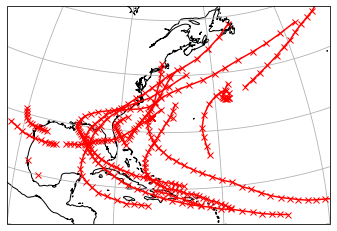

In [6]:
ax = utils.create_geoaxes()

for ID in hurricane_IDs[0:20]:
    utils.plot_hurricane_trajectory(df, ID, ax=ax)

## Part 1: Predicting whether or not a hurricane will make landfall

In [7]:
# Create dataframe of each individual hurricane
hurricane_IDs = df['ID'].unique()
hurricane_df = pd.DataFrame.from_dict({'ID':hurricane_IDs})
hurricane_df.set_index(['ID'])

for ID in hurricane_IDs:
    attrs = utils.get_hurricane_attributes(df, ID)
    for col in attrs:
        hurricane_df[col] = attrs[col]

In [11]:
hurricane_df.set_index(['ID'])

,Duration,Initial latitude,Initial longitude,Makes Landfall,Landfall latitude,Landfall longitude
ID,,,,,,
AL011851,34,19.4,-58.1,False,NaN,NaN
AL021851,34,19.4,-58.1,False,NaN,NaN
AL031851,34,19.4,-58.1,False,NaN,NaN
AL041851,34,19.4,-58.1,False,NaN,NaN
AL051851,34,19.4,-58.1,False,NaN,NaN
...,...,...,...,...,...,...
AL162019,34,19.4,-58.1,False,NaN,NaN
AL172019,34,19.4,-58.1,False,NaN,NaN
AL182019,34,19.4,-58.1,False,NaN,NaN
